In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()
# Country Data COUNTRY table
COUNTRY_df = pd.read_sql_query("select * from COUNTRY;", conn)
# League data from LEAGUE
LEAGUE_df = pd.read_sql_query("select * from LEAGUE;", conn)
# Match data from Matches - just pulling 1 year for now -2015/2016 might be latest year
# You can remove restriction if you want
#MATCH_df = pd.read_sql_query("select * from MATCH where SEASON = '2015/2016';", conn)
# Match data from Matches - just pulling 1 and relevant data for now - we can remove restriction later if we want
MATCH_df = pd.read_sql_query("SELECT DATE, LEAGUE_ID, HOME_TEAM_API_ID, AWAY_TEAM_API_ID, HOME_TEAM_GOAL, AWAY_TEAM_GOAL FROM MATCH WHERE SEASON = '2015/2016';",
conn)
PLAYER_df = pd.read_sql_query("select * from PLAYER;", conn)
PLAYER_ATTRIBUTES_df = pd.read_sql_query("select * from PLAYER_ATTRIBUTES;", conn)
TEAM_df = pd.read_sql_query("select * from TEAM;", conn)
TEAM_ATTRIBUTES_df = pd.read_sql_query("select * from TEAM_ATTRIBUTES;", conn)

# We calculate the "differential" for both the home team and away team

In [3]:
MATCH_df["HOME_DIFF"] = MATCH_df["home_team_goal"]- MATCH_df["away_team_goal"]
MATCH_df["AWAY_DIFF"] = MATCH_df["away_team_goal"]- MATCH_df["home_team_goal"]

MATCH_home_df=MATCH_df.loc[:,["date","home_team_api_id", "HOME_DIFF","league_id","away_team_api_id"]]
MATCH_away_df=MATCH_df.loc[:,["date","away_team_api_id", "AWAY_DIFF","league_id","home_team_api_id"]]



In [4]:
MATCH_away_df['W'] = 0
MATCH_away_df['L'] = 0
MATCH_away_df['T'] = 0
MATCH_home_df['W'] = 0
MATCH_home_df['L'] = 0
MATCH_home_df['T'] = 0


MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF >0, 'W'] = 1
MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF <0, 'L'] = 1
MATCH_away_df.loc[MATCH_away_df.AWAY_DIFF ==0, 'T'] = 1

MATCH_home_df.loc[MATCH_home_df.HOME_DIFF >0, 'W'] = 1
MATCH_home_df.loc[MATCH_home_df.HOME_DIFF <0, 'L'] = 1
MATCH_home_df.loc[MATCH_home_df.HOME_DIFF ==0, 'T'] = 1

MATCH_away_df.head(5)

,date,away_team_api_id,AWAY_DIFF,league_id,home_team_api_id,W,L,T
0,2015-07-24 00:00:00,8342,-1,1,9997,0,1,0
1,2015-07-25 00:00:00,9985,-1,1,8571,0,1,0
2,2015-07-25 00:00:00,1773,-2,1,9987,0,1,0
3,2015-07-25 00:00:00,8203,-2,1,8573,0,1,0
4,2015-07-25 00:00:00,9994,-2,1,10000,0,1,0


# We combine the home team data with the away team data to create 1 list of games, with the differential

In [5]:
MATCH_home_df = MATCH_home_df.rename(columns={"home_team_api_id": "team_api_id","HOME_DIFF":"DIFF","away_team_api_id":"opponent"})
MATCH_away_df = MATCH_away_df.rename(columns={"away_team_api_id": "team_api_id","AWAY_DIFF":"DIFF","home_team_api_id":"opponent"})

MATCH_away_df.head()

frames = [MATCH_home_df, MATCH_away_df]
all_games_unsorted = pd.concat(frames)
all_games = all_games_unsorted.sort_values(by=["team_api_id","date"])
all_games.reset_index(inplace=True)
all_games.head()

,index,date,team_api_id,DIFF,league_id,opponent,W,L,T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0


In [6]:
### We want to figure out the what the differential was for the next game as well.  
### We will make a copy of the table, and add "ng_" as a suffix to the columns for "next game"
next_game_unsorted = all_games.copy()
next_game_unsorted = next_game_unsorted.rename(columns={"DIFF": "ng_DIFF",
"team_api_id": "ng_team_api_id2",
"league_id": "ng_league_id",
"date": "ng_date",
"W": "ng_W",
"L": "ng_L",
"T": "ng_T" })

next_game = next_game_unsorted.sort_values(by=["ng_team_api_id2","ng_date"])
next_game.head()

,index,ng_date,ng_team_api_id2,ng_DIFF,ng_league_id,opponent,ng_W,ng_L,ng_T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0


# We will merge the original data to the copy, but shift the copy data by one row, so it will line up with the next game

In [7]:
#df_complete = pd.merge(all_games, next_game.shift(-1).fillna(0).astype(int), left_index=True, right_index=True)
df_complete = pd.merge(all_games, next_game.shift(-1).fillna(0), left_index=True, right_index=True)
df_complete.head()

,index_x,date,team_api_id,DIFF,league_id,opponent_x,W,L,T,index_y,ng_date,ng_team_api_id2,ng_DIFF,ng_league_id,opponent_y,ng_W,ng_L,ng_T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0,2084.0,2015-07-24 00:00:00,1601.0,2.0,15722.0,8028.0,1.0,0.0,0.0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0,2173.0,2015-08-03 00:00:00,1601.0,1.0,15722.0,8245.0,1.0,0.0,0.0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0,2188.0,2015-08-10 00:00:00,1601.0,0.0,15722.0,8033.0,0.0,0.0,1.0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1,2197.0,2015-08-16 00:00:00,1601.0,-1.0,15722.0,1957.0,0.0,1.0,0.0
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0,2204.0,2015-08-22 00:00:00,1601.0,3.0,15722.0,177361.0,1.0,0.0,0.0


# Oops! For the last game of the season (where we don't have a next game), checking the next game would have returned the next team's first game. We should just zero that out.

In [8]:
#df.loc[df.First_name == 'Bill', 'name_match'] = 'Match' 
df_complete.sort_values(by=["team_api_id","date"]).head()
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_DIFF"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_league_id"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"opponent_y"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_date"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_W"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_L"] = 0
df_complete.loc[df_complete.team_api_id != df_complete.ng_team_api_id2,
"ng_T"] = 0
df_complete.head()

,index_x,date,team_api_id,DIFF,league_id,opponent_x,W,L,T,index_y,ng_date,ng_team_api_id2,ng_DIFF,ng_league_id,opponent_y,ng_W,ng_L,ng_T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0,2084.0,2015-07-24 00:00:00,1601.0,2.0,15722.0,8028.0,1.0,0.0,0.0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0,2173.0,2015-08-03 00:00:00,1601.0,1.0,15722.0,8245.0,1.0,0.0,0.0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0,2188.0,2015-08-10 00:00:00,1601.0,0.0,15722.0,8033.0,0.0,0.0,1.0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1,2197.0,2015-08-16 00:00:00,1601.0,-1.0,15722.0,1957.0,0.0,1.0,0.0
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0,2204.0,2015-08-22 00:00:00,1601.0,3.0,15722.0,177361.0,1.0,0.0,0.0


# Let's delete all the extra columns we created

In [9]:
#df_complete.drop(['index_x','index_y','ng_date','ng_league_id'], axis=1, inplace=True)
df_complete.drop(['ng_date','ng_league_id'], axis=1, inplace=True)
df_complete.head()

,index_x,date,team_api_id,DIFF,league_id,opponent_x,W,L,T,index_y,ng_team_api_id2,ng_DIFF,opponent_y,ng_W,ng_L,ng_T
0,1995,2015-07-18 00:00:00,1601,-2,15722,8019,0,1,0,2084.0,1601.0,2.0,8028.0,1.0,0.0,0.0
1,2084,2015-07-24 00:00:00,1601,2,15722,8028,1,0,0,2173.0,1601.0,1.0,8245.0,1.0,0.0,0.0
2,2173,2015-08-03 00:00:00,1601,1,15722,8245,1,0,0,2188.0,1601.0,0.0,8033.0,0.0,0.0,1.0
3,2188,2015-08-10 00:00:00,1601,0,15722,8033,0,0,1,2197.0,1601.0,-1.0,1957.0,0.0,1.0,0.0
4,2197,2015-08-16 00:00:00,1601,-1,15722,1957,0,1,0,2204.0,1601.0,3.0,177361.0,1.0,0.0,0.0


# Now, lets find the most dominant team. We will do that by grouping by the bext team

In [10]:
df_teams = df_complete.groupby(['league_id','team_api_id'], as_index=False).sum()
team_merge = pd.merge(df_teams, TEAM_df, on="team_api_id")
team_merge.tail()

,league_id,team_api_id,index_x,DIFF,opponent_x,W,L,T,index_y,ng_team_api_id2,ng_DIFF,opponent_y,ng_W,ng_L,ng_T,id,team_fifa_api_id,team_long_name,team_short_name
183,24558,10190,116479,-25,354444,10,18,8,116478.0,366841.0,-27.0,346548.0,9.0,18.0,8.0,49479,898.0,FC St. Gallen,GAL
184,24558,10191,116489,-9,354440,10,15,11,116491.0,366877.0,-7.0,344484.0,10.0,14.0,11.0,49837,1715.0,FC Thun,THU
185,24558,10192,116498,31,354436,20,7,9,113596.0,366914.0,31.0,344193.0,20.0,7.0,8.0,49117,900.0,BSC Young Boys,YB
186,24558,10199,116463,9,354408,15,12,9,116089.0,367170.0,9.0,344229.0,15.0,12.0,8.0,49121,897.0,FC Luzern,LUZ
187,24558,10243,116522,-23,354232,7,16,13,113997.0,368754.0,-23.0,344040.0,7.0,16.0,12.0,49124,894.0,FC Zürich,ZUR


# For each league, we will append the team that has the maximum Differential. These are our dominant teams, their seasonal goal differentials, and their goal differentials per game.

In [11]:
leagues = team_merge.league_id.unique()
x = []
y = []
a = []
b = []
c = []
name = []
#df_test['DIFF'] = df_test['DIFF'].apply(np.array)
for l in leagues:
    df_test = team_merge[team_merge.league_id == l]
    x.append(df_test['team_api_id'].loc[df_test['DIFF'].idxmax()])
    name.append(df_test['team_short_name'].loc[df_test['DIFF'].idxmax()])
    #change "team_api_id" to "team_short_name" for Dominant Team Comparison barchart
    y.append(df_test['DIFF'].loc[df_test['DIFF'].idxmax()])
    a.append(df_test['W'].loc[df_test['DIFF'].idxmax()])
    b.append(df_test['L'].loc[df_test['DIFF'].idxmax()])
    c.append(df_test['T'].loc[df_test['DIFF'].idxmax()])
d = [x + y + z for x, y, z in zip(a, b, c)]
diff_per_game = [i/j for i,j in zip(y, d)]
diff_per_game = [ round(elem, 1) for elem in diff_per_game]
diff_per_game

[1.1, 0.9, 2.2, 1.9, 1.4, 1.8, 1.0, 1.9, 1.6, 2.2, 1.4]

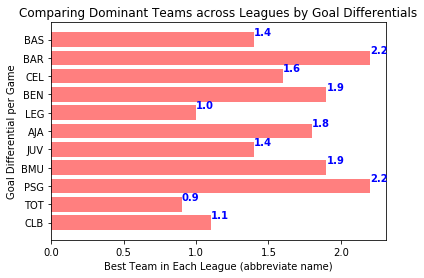

<Figure size 432x288 with 0 Axes>

In [12]:
# # x_axis = np.arange(0, 5, 0.1)
fig,ax = plt.subplots()
ax.barh(name, diff_per_game, color='r', alpha=0.5, align="center")
plt.ylabel("Goal Differential per Game")
plt.xlabel("Best Team in Each League (abbreviate name)")
plt.title("Comparing Dominant Teams across Leagues by Goal Differentials")
for i, v in enumerate(diff_per_game):
    ax.text(v, i + .25, str(v), color='blue', fontweight='bold')
plt.show()
# tick_locations = [value for value in x]
# plt.xticks(tick_locations, x)
#y = [34, 34, 83, 63, 55, 60, 30, 66, 62, 83, 50]
#x = array([8673, 8342, 9772, 9847, 8593, 8634, 9931, 9885, 9925, 9823, 8586], dtype=int64)
plt.savefig("DomTeamsGoalDiff.png")

In [13]:
dom_match = df_complete[df_complete.opponent_x.isin(x)]
#dom_match.opponent_y.value_counts()

In [14]:
df_teams.head()

df_DIFF = df_teams[["team_api_id","DIFF"]]

df_DIFF = df_DIFF.rename(columns={"DIFF": "total_DIFF"})


df_DIFF.head()

,team_api_id,total_DIFF
0,1773,-11
1,8203,-2
2,8342,34
3,8475,-17
4,8571,-4


In [15]:
# set team_api_id's DIFF
merge_table_all = pd.merge(dom_match, df_DIFF,left_on="team_api_id",
right_on="team_api_id")

merge_table_c = merge_table_all.rename(columns={"opponent_x": "dom_team",
"team_api_id": "team",
"opponent_y": "ng_opponent",
"total_DIFF": "team_season_DIFF"

})
merge_table_c.head()

,index_x,date,team,DIFF,league_id,dom_team,W,L,T,index_y,ng_team_api_id2,ng_DIFF,ng_opponent,ng_W,ng_L,ng_T,team_season_DIFF
0,2231,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,2005.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9
1,2127,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,2133.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9
2,32,2015-10-28 00:00:00,1773,-2,1,8342,0,1,0,45.0,1773.0,-2.0,9991.0,0.0,1.0,0.0,-11
3,189,2016-03-13 00:00:00,1773,-1,1,8342,0,1,0,1997.0,1957.0,0.0,0.0,0.0,0.0,0.0,-11
4,2212,2015-08-30 00:00:00,1957,0,15722,8673,0,0,1,2218.0,1957.0,-2.0,8025.0,0.0,1.0,0.0,-17


In [16]:
merge_table_b = pd.merge(merge_table_c, df_DIFF,left_on="dom_team",
right_on="team_api_id")
merge_table_b = merge_table_b.rename(columns={"total_DIFF":
"dom_season_DIFF"})
merge_table_b.drop(['team_api_id'], axis=1, inplace=True)
merge_table_b.head()

,index_x,date,team,DIFF,league_id,dom_team,W,L,T,index_y,ng_team_api_id2,ng_DIFF,ng_opponent,ng_W,ng_L,ng_T,team_season_DIFF,dom_season_DIFF
0,2231,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,2005.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30
1,2127,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,2133.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30
2,2212,2015-08-30 00:00:00,1957,0,15722,8673,0,0,1,2218.0,1957.0,-2.0,8025.0,0.0,1.0,0.0,-17,30
3,2108,2016-02-14 00:00:00,1957,-4,15722,8673,0,1,0,2114.0,1957.0,1.0,8025.0,1.0,0.0,0.0,-17,30
4,2031,2015-10-25 00:00:00,2182,1,15722,8673,1,0,0,2034.0,2182.0,0.0,8025.0,0.0,0.0,1.0,-1,30


In [17]:
merge_table = pd.merge(merge_table_b, df_DIFF,left_on="ng_opponent",
right_on="team_api_id")
merge_table = merge_table.rename(columns={"total_DIFF":
"ng_opp_season_DIFF"})
merge_table.head(5)

,index_x,date,team,DIFF,league_id,dom_team,W,L,T,index_y,ng_team_api_id2,ng_DIFF,ng_opponent,ng_W,ng_L,ng_T,team_season_DIFF,dom_season_DIFF,team_api_id,ng_opp_season_DIFF
0,2231,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,2005.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,2186,15
1,2127,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,2133.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,2186,15
2,2222,2015-09-11 00:00:00,8021,0,15722,8673,0,0,1,2228.0,8021.0,2.0,2186.0,1.0,0.0,0.0,4,30,2186,15
3,2118,2016-02-21 00:00:00,8021,-1,15722,8673,0,1,0,2124.0,8021.0,1.0,2186.0,1.0,0.0,0.0,4,30,2186,15
4,2086,2015-07-26 00:00:00,8033,-5,15722,8673,0,1,0,2172.0,8033.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,2186,15


In [18]:
merge_table.drop(['team_api_id'], axis=1, inplace=True)

#merge_table.value_count("ng_opponent")
#merge_table.ng_opponent.value_counts()
merge_table = merge_table.rename(columns={"ng_team_api_id2": "shift_team",
"league_id": "league",
"ng_opponent": "ng_oppo",
"team_season_DIFF": "team_szn_DIFF",
"dom_season_DIFF": "dom_szn_DIFF",
"ng_opp_season_DIFF":
"ng_oppo_szn_DIFF" })

In [20]:
### DATA TABLES

# df_teams_WLT
# Has the total W/L/T and winning percentage of each team

# merge_table
# Has all the rows

# Note:
# shift_team is the team we merged on when we shifted. If it's not the same
# as team it is the last game of the season

In [73]:
LEAGUE_df

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


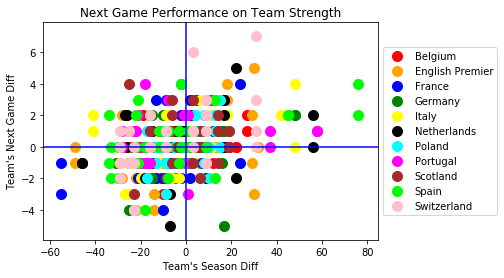

In [97]:
# scatter_x = merge_table["team_szn_DIFF"]
# scatter_y = merge_table["ng_DIFF"]
# group = merge_table["league"]
# group_unique = group.unique()
# cdict = {1:"red",1729:"orange",4769:"blue",7809:"green",10257:"yellow",13274:"black",15722:"cyan",17642:"magenta",19694:"brown",21518:"lime",24558:"pink"}
# ldict = {1:"Belgium",1729:"Eng Premier",4769:"France",7809:"Germany",10257:"Italy",13274:"Netherlands",15722:"Poland",17642:"Portugal",19694:"Scotland",21518:"Spain",24558:"Switzerland"}
# fig, ax = plt.subplots()
# for index, row in merge_table.iterrows():
#     g = group[index]
#     ax.scatter(scatter_x[index], scatter_y[index], c = cdict[g], label = ldict[g], s = 100)
l1 = plt.scatter(merge_table.loc[merge_table["league"]==1, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==1, ["ng_DIFF"]], c = "r", label = "Belgium", s = 100)
l2 = plt.scatter(merge_table.loc[merge_table["league"]==1729, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==1729, ["ng_DIFF"]], c = "orange", label = "English Premier", s = 100)
l3 = plt.scatter(merge_table.loc[merge_table["league"]==4769, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==4769, ["ng_DIFF"]], c = "blue", label = "France", s = 100)
l4 = plt.scatter(merge_table.loc[merge_table["league"]==7809, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==7809, ["ng_DIFF"]], c = "green", label = "Germany", s = 100)
l5 = plt.scatter(merge_table.loc[merge_table["league"]==10257, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==10257, ["ng_DIFF"]], c = "yellow", label = "Italy", s = 100)
l6 = plt.scatter(merge_table.loc[merge_table["league"]==13274, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==13274, ["ng_DIFF"]], c = "black", label = "Netherlands", s = 100)
l7 = plt.scatter(merge_table.loc[merge_table["league"]==15722, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==15722, ["ng_DIFF"]], c = "cyan", label = "Poland", s = 100)
l8 = plt.scatter(merge_table.loc[merge_table["league"]==17642, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==17642, ["ng_DIFF"]], c = "magenta", label = "Portugal", s = 100)
l9 = plt.scatter(merge_table.loc[merge_table["league"]==19694, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==19694, ["ng_DIFF"]], c = "brown", label = "Scotland", s = 100)
l10 = plt.scatter(merge_table.loc[merge_table["league"]==21518, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==21518, ["ng_DIFF"]], c = "lime", label = "Spain", s = 100)
l11 = plt.scatter(merge_table.loc[merge_table["league"]==24558, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==24558, ["ng_DIFF"]], c = "pink", label = "Switzerland", s = 100)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Next Game Diff")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
plt.title("Next Game Performance on Team Strength")
plt.show()
# plt.scatter(merge_table["team_szn_DIFF"], merge_table["ng_DIFF"], marker="o", facecolors="red", edgecolors="black",
#             alpha=0.75)


In [20]:
#plt.scatter(merge_table['team_szn_DIFF'], merge_table['DIFF'], label=merge_table['league'])

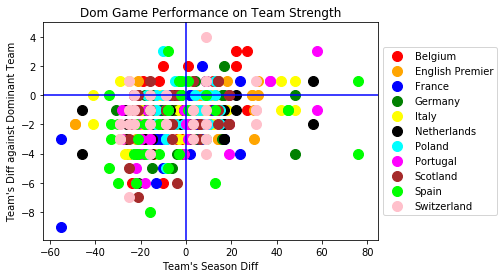

In [98]:
# scatter_x = merge_table["team_szn_DIFF"]
# scatter_y = merge_table["DIFF"]
# group = merge_table["league"]
# group_unique = group.unique()
# cdict = {1:"red",1729:"orange",4769:"blue",7809:"green",10257:"yellow",13274:"black",15722:"cyan",17642:"magenta",19694:"brown",21518:"lime",24558:"pink"}
# fig, ax = plt.subplots()
# for index, row in merge_table.iterrows():
#     g = group[index]
#     ax.scatter(scatter_x[index], scatter_y[index], c = cdict[g], s = 100)
    #ax.scatter(merge_table['team_szn_DIFF'], merge_table['DIFF'], c=cdict[g], s=100)  
n1 = plt.scatter(merge_table.loc[merge_table["league"]==1, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==1, ["DIFF"]], c = "r", label = "Belgium", s = 100)
n2 = plt.scatter(merge_table.loc[merge_table["league"]==1729, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==1729, ["DIFF"]], c = "orange", label = "English Premier", s = 100)
n3 = plt.scatter(merge_table.loc[merge_table["league"]==4769, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==4769, ["DIFF"]], c = "blue", label = "France", s = 100)
n4 = plt.scatter(merge_table.loc[merge_table["league"]==7809, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==7809, ["DIFF"]], c = "green", label = "Germany", s = 100)
n5 = plt.scatter(merge_table.loc[merge_table["league"]==10257, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==10257, ["DIFF"]], c = "yellow", label = "Italy", s = 100)
n6 = plt.scatter(merge_table.loc[merge_table["league"]==13274, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==13274, ["DIFF"]], c = "black", label = "Netherlands", s = 100)
n7 = plt.scatter(merge_table.loc[merge_table["league"]==15722, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==15722, ["DIFF"]], c = "cyan", label = "Poland", s = 100)
n8 = plt.scatter(merge_table.loc[merge_table["league"]==17642, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==17642, ["DIFF"]], c = "magenta", label = "Portugal", s = 100)
n9 = plt.scatter(merge_table.loc[merge_table["league"]==19694, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==19694, ["DIFF"]], c = "brown", label = "Scotland", s = 100)
n10 = plt.scatter(merge_table.loc[merge_table["league"]==21518, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==21518, ["DIFF"]], c = "lime", label = "Spain", s = 100)
n11 = plt.scatter(merge_table.loc[merge_table["league"]==24558, ["team_szn_DIFF"]],merge_table.loc[merge_table["league"]==24558, ["DIFF"]], c = "pink", label = "Switzerland", s = 100)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Team's Season Diff")
plt.ylabel("Team's Diff against Dominant Team")
plt.axhline(0, color='b')
plt.axvline(0, color='b')
plt.title("Dom Game Performance on Team Strength")
plt.show()
#plt.scatter(merge_table["team_szn_DIFF"], merge_table["DIFF"], marker="o", facecolors="red", edgecolors="black",alpha=0.75)

In [25]:
bins = [-60, -25, 0, 20, 35, 80]
group_names = ["F", "D", "C", "B", "A"]
merge_table["Team Quality"] = pd.cut(merge_table["team_szn_DIFF"], bins, labels=group_names)
merge_table.head()
#carving out dom_game and next_game results from merge_table 
#then concatenating them with an added column to identify "Dom" or "Next"
#so we can arrange two boxplots in the same chart
dom_game = merge_table[["Team Quality","DIFF"]]
dom_game["Game"] = "dom"
dom_game.head()
next_game = merge_table[["Team Quality", "ng_DIFF"]]
next_game = next_game.rename(columns={"ng_DIFF":"DIFF"})
next_game["Game"] = "next"
both_games = pd.concat([dom_game,next_game],sort=False)
both_games.head()

,index_x,date,team,DIFF,league,dom_team,W,L,T,index_y,shift_team,ng_DIFF,ng_oppo,ng_W,ng_L,ng_T,team_szn_DIFF,dom_szn_DIFF,ng_oppo_szn_DIFF,Team Quality
0,2231,2015-09-20 00:00:00,1601,-3,15722,8673,0,1,0,2005.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D
1,2127,2016-02-28 00:00:00,1601,-2,15722,8673,0,1,0,2133.0,1601.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D
2,2222,2015-09-11 00:00:00,8021,0,15722,8673,0,0,1,2228.0,8021.0,2.0,2186.0,1.0,0.0,0.0,4,30,15,C
3,2118,2016-02-21 00:00:00,8021,-1,15722,8673,0,1,0,2124.0,8021.0,1.0,2186.0,1.0,0.0,0.0,4,30,15,C
4,2086,2015-07-26 00:00:00,8033,-5,15722,8673,0,1,0,2172.0,8033.0,-1.0,2186.0,0.0,1.0,0.0,-9,30,15,D


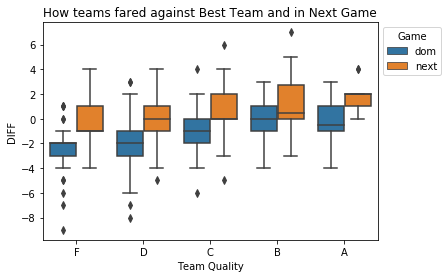

In [23]:
#data = both_games.melt(id_vars=['Team Quality'], var_name='Game', value_name='DIFF')
sns.boxplot(data=both_games, x='Team Quality', y='DIFF', hue='Game')
plt.legend(title='Game', loc='upper left', bbox_to_anchor=(1, 1))
plt.title("How teams fared against Best Team and in Next Game")
plt.savefig("Dom-Next-Game BoxPlot.png")

In [24]:
# ng_bplot = sns.boxplot(y='ng_DIFF', x='Team Quality', data=merge_table, width=0.5, palette="colorblind")
# plt.ylabel("Goal Differential")
# plt.title("How various quality teams fared in the next game")
# plt.axhline(0, color='b')
# plt.savefig("NextGame BoxPlot.png")

# dom_bplot = sns.boxplot(y='DIFF', x='Team Quality', data=merge_table, width=0.5, palette="colorblind")
# plt.ylabel("Goal Differential")
# plt.title("How various quality teams fared against the Dominant Team")
# plt.axhline(0, color='b')
# plt.savefig("DomGame BoxPlot.png")

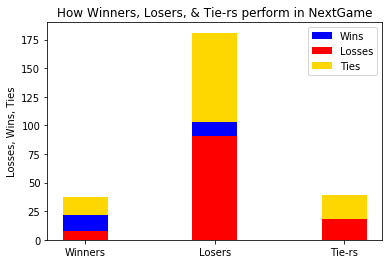

<Figure size 432x288 with 0 Axes>

In [71]:
winners_df = merge_table.loc[merge_table["DIFF"] > 0, ["team", "ng_DIFF", "team_season_DIFF","Team Quality"]]
winners_wins = winners_df[winners_df["ng_DIFF"]>0]["ng_DIFF"].count()
winners_losses = winners_df[winners_df["ng_DIFF"]<0]["ng_DIFF"].count()
winners_ties = winners_df[winners_df["ng_DIFF"]==0]["ng_DIFF"].count()
winners_results = [winners_wins,winners_losses,winners_ties]

losers_df = merge_table.loc[merge_table["DIFF"] < 0, ["team", "ng_DIFF", "team_season_DIFF","Team Quality"]]
losers_wins = losers_df[losers_df["ng_DIFF"]>0]["ng_DIFF"].count()
losers_losses = losers_df[losers_df["ng_DIFF"]<0]["ng_DIFF"].count()
losers_ties = losers_df[losers_df["ng_DIFF"]==0]["ng_DIFF"].count()
losers_results = [losers_wins,losers_losses,losers_ties]

ties_df = merge_table.loc[merge_table["DIFF"] == 0, ["team", "ng_DIFF", "team_season_DIFF","Team Quality"]]
ties_wins = ties_df[ties_df["ng_DIFF"]>0]["ng_DIFF"].count()
ties_losses = ties_df[ties_df["ng_DIFF"]<0]["ng_DIFF"].count()
ties_ties = ties_df[ties_df["ng_DIFF"]==0]["ng_DIFF"].count()
ties_results = [ties_wins,ties_losses,ties_ties]
results_df = pd.DataFrame({'Winners': winners_results, 'Losers': losers_results, 'Tie-rs': ties_results})
results_df = results_df.transpose()
results_df = results_df.rename(columns={"0":"Wins", "1":"Losses", "2":"Ties"})
results_df

N = 3
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, results_df[0], width, color = "blue")
p2 = plt.bar(ind, results_df[1], width, color = "red")
p3 = plt.bar(ind, results_df[2], width, color = "gold", bottom=results_df[0])
plt.ylabel('Losses, Wins, Ties')
plt.title('How Winners, Losers, & Tie-rs perform in NextGame')
plt.xticks(ind, ('Winners', 'Losers', 'Tie-rs'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Wins', 'Losses','Ties'))
plt.show()
plt.savefig("NextGame-Stacked.png")

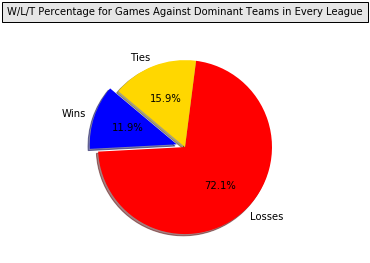

In [104]:
# Dom team game
#plt.figure(1)
labels = ['Wins', 'Losses', 'Ties']
sizes = [11.94, 72.15, 15.92]
colors = ['blue', 'red', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
p1 = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("W/L/T Percentage for Games Against Dominant Teams in Every League", bbox={'facecolor':'0.9', 'pad':5}, fontsize=10, y=1.08)

#plt.figure(2)

plt.show()
# plt.savefig("DomGame PieChart.png")

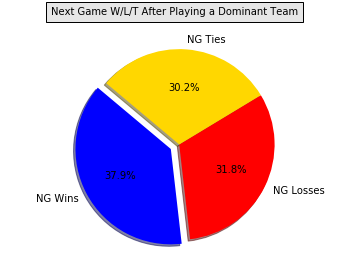

<Figure size 432x288 with 0 Axes>

In [105]:
# Next game
labels1 = ['NG Wins', 'NG Losses', 'NG Ties']
sizes1 = [37.93, 31.83, 30.24]
colors1 = ['blue', 'red', 'gold']
explode1 = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes1, explode=explode1, labels=labels1, colors=colors1,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
# plt.title(figure_title, )
plt.title("Next Game W/L/T After Playing a Dominant Team", bbox={'facecolor':'0.9', 'pad':5}, fontsize=10, y=1.08)
plt.show()
plt.savefig("NextGame PieChart.png")

In [122]:
# df_teams.head() has the
df_teams_WLT = df_teams[["league_id","team_api_id","W","L","T"]].copy()
#df_teams_WLT["win_%"]=df_teams_WLT[['T']] + df_teams_WLT[['L']]
#+ df_teams_WLT.L + df_teams_WLT.L
#df_teams_WLT.head()
#df_teams_WLT[["win_percent"]]=df_teams_WLT["W"


df_teams_WLT['total_games'] = df_teams_WLT.apply(lambda x: x['W'] + x['L']
+ x['T'], axis=1)
df_teams_WLT['win_rate'] = df_teams_WLT.apply(lambda x: x['W'] /
x['total_games'], axis=1)
df_teams_WLT['tie_rate'] = df_teams_WLT.apply(lambda x: x['T'] /
x['total_games'], axis=1)
df_teams_WLT['loss_rate'] = df_teams_WLT.apply(lambda x: x['L'] /
x['total_games'], axis=1)
df_teams_WLT.head()

,league_id,team_api_id,W,L,T,total_games,win_rate,tie_rate,loss_rate
0,1,1773,7,15,8,30,0.233333,0.266667,0.500000
1,1,8203,10,13,7,30,0.333333,0.233333,0.433333
2,1,8342,21,8,1,30,0.700000,0.033333,0.266667
3,1,8475,9,15,6,30,0.300000,0.200000,0.500000
4,1,8571,10,11,9,30,0.333333,0.300000,0.366667


In [119]:
df_teams_WLT["points"] = df_teams_WLT["W"]*3 + df_teams_WLT["T"]
bins = [0, 36, 42, 49, 60.0,999]
group_names = ["F", "D", "C", "B", "A"]
df_teams_WLT["Team Win Pctg"] = pd.cut(df_teams_WLT["points"], bins, labels=group_names)
df_teams_WLT.head(5)
#plt.bar(df_teams_WLT["Team Win Pctg"], merge_table["ng_WIN"].sum(), color='r', alpha=0.5, align="center")
#df_teams_WLT["points"] = (df_teams_WLT.W*3 + df_teams_WLT.T)
#+ df_teams_WLT["T"]
#df_teams_WLT["points"] = df_teams_WLT["points"] + df_teams_WLT["tie_points"]

df_teams_WLT.head() 
    


188

In [ ]:
#df_teams_WLT.head()

#60     / 49   /42      / 36
# 37.6 / 75.2 / 112.8 / 150

#df_teams[df_teams_WLT.points > 40].count()#  122
#df_teams[df_teams_WLT.points > 59].count() #36

#df_teams[df_teams_WLT.points > 60].count() #36 
#df_teams[df_teams_WLT.points > 49].count() #73
#df_teams[df_teams_WLT.points > 42].count() #113
#df_teams[df_teams_WLT.points > 36].count() #### 150
#94



#df_teams[df_teams_WLT.points > 70].count() #94

#df_teams[df_teams_WLT.points > 50].count()  62


#df_teams[df_teams_WLT.loss_rate > .56].count()  #10 for 05%
# df_teams[df_teams_WLT.loss_rate > .48].count()  #34

#------# df_teams[df_teams_WLT.loss_rate > .48].count()  #34
#------#df_teams[df_teams_WLT.loss_rate > .42].count()   
#------df_teams[df_teams_WLT.loss_rate > .36].count()  #141 for 75%  113
# ---df_teams[df_teams_WLT.loss_rate > .28].count()  #141 for 75%  141

In [ ]:
#merge_table # 377
#merge_table_bins = pd.merge(merge_table, df_teams_WLT,left_on="team_api_id", right_on="team_api_id")
#merge_table_bins.head()
#df_teams_WLT=df_teams_WLT.sort_values(by=["team_api_id"])
# 188
#all_games = all_games_unsorted.sort_values(by=["team_api_id","date"])
#df_teams_WLT # 188 rows

merge_table_group = merge_table.groupby(['league','team'], as_index=False).sum()

merge_table_group['total_ng'] = merge_table_group.apply(lambda x: x['W'] + x['L'] + x['T'], axis=1)
merge_table_group['win_rate_ng'] = merge_table_group.apply(lambda x: x['W'] / x['total_ng'], axis=1)
merge_table_group['loss_rate_ng'] = merge_table_group.apply(lambda x: x['L'] / x['total_ng'], axis=1)
merge_table_group['tie_rate_ng'] = merge_table_group.apply(lambda x: x['T'] / x['total_ng'], axis=1)
  
merge_table_group.head(5)


#merge_table_group # 177 -  11

#df_teams_WLT.head() #  team_api_id
#merge_table_group.head()  # team

merge_table_bins = pd.merge(merge_table_group, df_teams_WLT,left_on="team", right_on="team_api_id")
merge_table_bins.columns
# team / BIN / LEAGUE / 


#df_teams_WLT # 188

#df_teams_WLT.sort_values(by=["team_api_id"])


#unique_df_teams  = df_teams.team_api_id.unique()
#unique_df_teams

In [ ]:
merge_table_bins.drop(['shift_team','ng_oppo','dom_team','league','team_api_id'], axis=1, inplace=True)
merge_table_bins.head(6)

In [ ]:
merge_table_group_bin = merge_table_bins.groupby(['Team Win Pctg'], as_index=False).sum()
merge_table_group_bin_mean = merge_table_bins.groupby(['Team Win Pctg'], as_index=False).mean()

merge_table_group_bin.head(12)
merge_table_group_bin.columns
#merge_table_group_bin.drop(['league','team','dom_team','shift_team','team_api_id'], axis=1, inplace=True)
merge_table_group_bin_mean.head()    

In [ ]:
merge_table_group_bin_mean.drop(['team','DIFF','W_x','L_x','T_x','ng_DIFF','ng_W','ng_L'], axis=1, inplace=True)
merge_table_group_bin_mean.head()

In [ ]:
# merge_table_group_bin.head()

# merge_table_group_bin.columns

merge_table_group_bin['total_ng'] = merge_table_group_bin.apply(lambda x: x['ng_W'] + x['ng_L'] + x['ng_T'], axis=1)
merge_table_group_bin['win_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_W'] / x['total_ng'], axis=1)
merge_table_group_bin['loss_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_L'] / x['total_ng'], axis=1)
merge_table_group_bin['tie_rate_ng'] = merge_table_group_bin.apply(lambda x: x['ng_T'] / x['total_ng'], axis=1)

merge_table_group_bin.head()

In [ ]:
merge_table_group_bin_mean.set_index('Team Win Pctg',inplace=True)
merge_table_group_bin.set_index('Team Win Pctg',inplace=True)

In [ ]:
fig=plt.figure()

ax=fig.add_subplot(111)
ax2=ax.twinx()


width=.25

#ax = x.plot(kind='bar', legend=False)
patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='best')
ax.legend(patches, labels, loc='lower left')
ax2.legend(patches, labels, loc='lower left')


colors = ["lime","seagreen","darkgreen"]
colors2 = ["thistle", "plum","mediumorchid"]

merge_table_group_bin_mean.loc[:,['win_rate','tie_rate','loss_rate']].plot.bar(stacked=True,width=width,position=0, color=colors, ax=ax,align='center')
#figsize=(15,15),
#merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=1,ax=ax2)
merge_table_group_bin.loc[:,['win_rate_ng','tie_rate_ng','loss_rate_ng']].plot.bar(stacked=True,width=width,position=1, color=colors2, figsize=(12,5),ax=ax2,align='center')

ax.legend(patches, labels, loc='best')
ax2.legend(patches, labels, loc='right')
#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7),position=1,ax=ax)

#plt.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))

#plt.show()
#merge_table_group_bin
ax.legend(fancybox=True, framealpha=0.5)
ax.legend(loc='upper left') 
ax2.legend(fancybox=True, framealpha=0.5)
ax2.legend(loc='lower left') 


#plt.legend(loc='best')

In [ ]:
fig=plt.figure()

ax=fig.add_subplot(111)
ax2=ax.twinx()


width=.3

colors = ["#006D2C", "#31A354","#74C476"]
colors2 = ["thistle", "plum","indigo"]

merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True,width=width, color=colors, figsize=(15,10),position=0,ax=ax)
merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=1,ax=ax2)
[' ',' ',' '].plot.bar(stacked=True,width=width, color=colors2, figsize=(15,10),position=2,ax=ax2)


#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7),position=1,ax=ax)


#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))

plt.show()
#merge_table_group_bin

In [ ]:
#df_complete.drop(['index_x','index_y','ng_date','ng_league_id'], axis=1, inplace=True)
merge_table_group_bin.drop(['league','team','DIFF','dom_team','shift_team','team_api_id','win_rate','loss_rate','tie_rate'], axis=1, inplace=True)
merge_table_group_bin.head()

In [ ]:
colors = ["#006D2C", "#31A354","#74C476"]
#merge_table_group_bin.loc[:,['W_x','L_x','T_x']].plot.bar(stacked=True, color=colors, figsize=(10,7))
#index = ["F","D","C","B","A"]
hello = merge_table_group_bin.loc[:,['ng_W','ng_L','ng_T']]#.plot.bar(stacked=True, color=colors, figsize=(10,7))
hello
#hello.plot.bar(stacked=True, color=colors, figsize=(10,7))

#dfx = pd.DataFrame(columns=['a', 'b', 'c', 'd'])
#dfx.plot()

#pd.DataFrame({'lab':['A', 'B', 'C','D','F']})
#merge_table_group_bin.head()

In [ ]:
data = [[2000, 2000, 2000, 2001, 2001, 2001, 2002, 2002, 2002],
        ['Jan', 'Feb', 'Mar', 'Jan', 'Feb', 'Mar', 'Jan', 'Feb', 'Mar'],
        [1, 2, 3, 4, 5, 6, 7, 8, 9]]

rows = zip(data[0], data[1], data[2])
headers = ['Year', 'Month', 'Value']
df = pd.DataFrame(rows, columns=headers)

df

In [ ]:
pivot_df = df.pivot(index='Year', columns='Month', values='Value')
pivot_df

In [ ]:
colors = ["#006D2C", "#31A354","#74C476"]
pivot_df.loc[:,['Jan','Feb', 'Mar']].plot.bar(stacked=True, color=colors, figsize=(10,7))

# Years = BINS  
# Months = W L T 

In [ ]:
#plt.bar(merge_table_bins["Team Win Pctg"], merge_table_bins["W_y"].unique(), color='r', alpha=0.5, align="center")

#pivot_df = df.pivot(index='Year', columns='Month', values='Value')


# This gives error . . . 

In [ ]:
                                                    Add
1773 7 15 8 30 0.233333 0.500000 0.266667 F 


8203 10 13 7 30 0.333333 0.433333 0.233333 F 


8342 21 8 1 30 0.700000 0.266667 0.033333 A 


8475 9 15 6 30 0.300000 0.500000 0.200000 F 


8571 10 11 9 30 0.333333 0.366667 0.300000 F 



# add to the bins, ng_

    next game   current game
    w  L   T   
A   ?  ?   ?
B   ?  ?   ?
C   ?  ?   ?
D   ?  ?   ?
F   ?  ?   ?